In [2]:
import mesa

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random
import networkx as nx   



sns.set(style="whitegrid")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# simple model
class userAgent(mesa.Agent):
    
    def __init__( self, unique_id, model, d):
        
        super().__init__(unique_id, model)
        
        self.d = d

        self.opinion = random.uniform(0, 1) # initial opinion
        self.peer_trust = random.uniform(0, 1)
        self.tendency_to_share = random.uniform(0, 1)
        
        temp = random.uniform(0, 1)
        if temp < 1.0/3.0:
            self.risk_sensitivity = 0 # low risk sensitivity
        else:
            temp2 = random.uniform(0, 1)
            if temp2 < 0.5:
                self.risk_sensitivity = 2 # high risk sensitivity
            else:
                self.risk_sensitivity = 1 # medium risk sensitivity
                
        # to keep track of the other agent in the communication
        self.other_id = -1
        self.other_op = -1
        self.old_op = -1
        self.update_count = 0
        
        self.update_status = False
        self.share_status = False
        
    '''
    This function is for simple opinion update process using only peer trust
    
    ''' 
    def update_opinion_simple_Deffuant(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 

        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            
            # record the number of times an agent is being selected as a nieghbor
            other_agent.update_count = other_agent.update_count + 1
               
            # record the nieghbor data
            self.other_op = other_agent.opinion
            self.other_id = other_agent.unique_id
          
            # Update opinions
            saved_opinion = self.opinion
            self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)
            other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

            
    '''
    This function is for updating opinions using peer trust and d (only simialr agent communicate)
    ''' 
    def update_opinion_simple_Deffuant_with_d(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 

        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            
            # record the number of times an agent is being selected as a nieghbor
            other_agent.update_count = other_agent.update_count + 1
            
            # record the nieghbor data
            self.other_op = other_agent.opinion
            self.other_id = other_agent.unique_id
            
            # Update opinions
            if abs(self.opinion - other_agent.opinion) < self.d:
                self.update_status = True
                saved_opinion = self.opinion
                self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)
                other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)
          
            else:
                self.update_status = False
                
                
    '''
    This function is for opinion update process using peer trust - risk sensitivity 
    ''' 
    def update_opinion_Deffuant_with_risk(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 

        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            
            # record the number of times an agent is being selected as a nieghbor
            other_agent.update_count = other_agent.update_count + 1
            
            # record the nieghbor data
            self.other_op = other_agent.opinion
            self.other_id = other_agent.unique_id
            
            saved_opinion = self.opinion
            self.old_op = saved_opinion
            
            self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

            if self.risk_sensitivity == 0:
                self.opinion = self.opinion / 2.0
            elif self.risk_sensitivity == 2:
                self.opinion = (1.0 + self.opinion) / 2.0

            other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

            if other_agent.risk_sensitivity == 0:
                other_agent.opinion = other_agent.opinion / 2.0
            elif other_agent.risk_sensitivity == 2:
                other_agent.opinion = (1.0 + other_agent.opinion) / 2.0
    
    
    '''
    This function is for opinion update process using all agent varibales 
    (peer trust - risk sensitivity - tendency to share)
    '''
    def update_opinion_Deffuant_with_R_and_B(self):

        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 
        if len(neighbors) > 0:
            
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion
            
            # record the nieghbor data
            self.other_op = other_agent.opinion
            self.other_id = other_agent.unique_id
            
            self.old_op = saved_opinion

            # other agent speek
            speak_prob = other_agent.opinion ** (1.0 / other_agent.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

                if self.risk_sensitivity == 0:
                    self.opinion = self.opinion / 2.0
                elif self.risk_sensitivity == 2:
                    self.opinion = (1.0 + self.opinion) / 2.0
                    
                self.update_status = True
            
            else:
                self.update_status = False
                


            # current agent speek
            speak_prob = self.opinion ** (1.0 / self.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

                if other_agent.risk_sensitivity == 0:
                    other_agent.opinion = other_agent.opinion / 2.0
                elif other_agent.risk_sensitivity == 2:
                    other_agent.opinion = (1.0 + other_agent.opinion) / 2.0
                    
                self.share_status = True
            
            else:
                self.share_status = False
                
     
    
    '''
    This function is for opinion update process using (peer trust - tendency to share)
    '''
    def update_opinion_Deffuant_with_B(self):

        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 
        if len(neighbors) > 0:
            
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion
            
            # record the nieghbor data
            self.other_op = other_agent.opinion
            self.other_id = other_agent.unique_id
            
            self.old_op = saved_opinion

            # other agent speek
            speak_prob = other_agent.opinion ** (1.0 / other_agent.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

                self.update_status = True
            
            else:
                self.update_status = False
                


            # current agent speek
            speak_prob = self.opinion ** (1.0 / self.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

                self.share_status = True
            
            else:
                self.share_status = False
                
    
    
    '''
    A method for executing the peer-to-peer communication based on the destials provided in the C code file 
    '''
    def communicate(self):
        # get all the connected neighbors
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False)        
    
        # select another agent randomly
        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))

            # save the opinion of the other agent
            other_saved_opinion = other_agent.opinion

            # the current agent speaks
            speak_prob = self.opinion ** (1.0 / self.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (self.opinion - other_agent.opinion)

                if self.risk_sensitivity == 2: # alarmist speaker
                    if other_agent.risk_sensitivity == 2 and self.opinion >= 0.5: # both agents are alarmist
                        other_agent.opinion = (1.0 + other_agent.opinion) / 2.0 # listener increase alarmism
                    if self.opinion < 0.5: 
                        other_agent.opinion = other_agent.opinion / 2.0 # listener decrease alarmism

                else: # not alarmist spreaker
                    if self.opinion > 0.5:
                        other_agent.opinion = (1.0 + other_agent.opinion) / 2.0

            # the other agent speaks
            other_speak_prob = other_saved_opinion ** (1.0 / other_agent.tendency_to_share)
            if random.uniform(0, 1) < other_speak_prob:
                self.opinion = self.opinion + 1.0 * self.peer_trust * (other_saved_opinion - self.opinion)

                if other_agent.risk_sensitivity == 2: 
                    if self.risk_sensitivity == 2 and other_saved_opinion >= 0.5:
                        self.opinion = (1.0 + self.opinion) / 2.0
                    if other_saved_opinion < 0.5:
                        self.opinion = self.opinion / 2.0

                else:
                    if other_saved_opinion > 0.5:
                        self.opinion = (1.0 + self.opinion) / 2.0


#             self.opinion_state = self.set_opinion_state(self.opinion)
#             other_agent.opinion_state = other_agent.set_opinion_state(other_agent.opinion)
        
            
            
            
    def step(self):
#         self.update_opinion_simple_Deffuant() ## only P
#         self.update_opinion_simple_Deffuant_with_d() ## P and d
#         self.update_opinion_Deffuant_with_risk() ## P and R
#         self.update_opinion_Deffuant_with_R_and_B() ## P & R & B
        self.update_opinion_Deffuant_with_B() ## P and B
#         self.communicate() ## C code implementation
        
        
        
#####################################################


def opinion_avg(model):
    return sum(a.opinion for a in model.grid.get_all_cell_contents())/model.num_agents

def peer_trust_avg(model):
    return sum(a.peer_trust for a in model.grid.get_all_cell_contents())/model.num_agents

#####################################################

class opinionsModel(mesa.Model):
    
    def __init__(self, N = 100 , d = 0):
      
        self.num_agents = N
        self.d = d

        self.G = nx.complete_graph(n = self.num_agents)
        self.datacollector = mesa.DataCollector(
            model_reporters = {
                "op_avg": opinion_avg,
                "peer_trust_avg" : peer_trust_avg,
            },
            agent_reporters = {
                "opinion" : "opinion", 
                "peer_trust" : "peer_trust",
                "risk_sensitivity": "risk_sensitivity",
                "tendency_to_share" : "tendency_to_share",
                "old_op" : "old_op",
                "update_status" : "update_status",
                "share_status" : "share_status",
#                 "update_count" : "update_count",
                "other_id" : "other_id",
                "other_op" : "other_op",
                
            }
        )

        self.grid = mesa.space.NetworkGrid(self.G)
        self.schedule = mesa.time.RandomActivation(self)
#         self.schedule = mesa.time.SimultaneousActivation(self)

        for i, node in enumerate(self.G.nodes()):           
            a = userAgent(i, self, d)
            self.schedule.add(a)
            self.grid.place_agent(a, node)
            
        self.datacollector.collect(self)

        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        

## 1. Understand how opinion update is being executed in the simplest model (only peer trust)

This is a simple version of the model with only peer trust 

my aim here is to understand how the individual interactions between 2 agents is happening. 

### Test Small population - No d

In [240]:
model = opinionsModel(N = 10)

In [241]:
num_steps = 10 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()

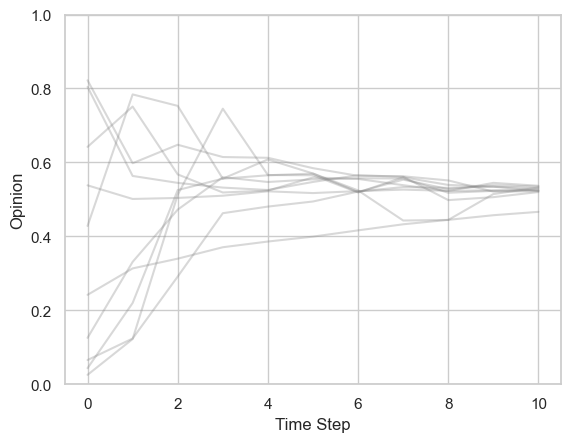

In [242]:
for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.3)

plt.ylim(0,1)
    
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

In [243]:
data = model.datacollector.get_agent_vars_dataframe()

In [248]:
d = data.reset_index()
d = d.pivot_table(index='AgentID', columns='Step', values='opinion')
d.reset_index(inplace=True)

d

Step  AgentID         0         1         2         3         4         5  \
0           0  0.065292  0.123556  0.291171  0.462602  0.480468  0.494267   
1           1  0.537992  0.501094  0.503885  0.509931  0.521817  0.517024   
2           2  0.125336  0.330913  0.472324  0.559910  0.547020  0.554114   
3           3  0.428105  0.783974  0.752938  0.555942  0.565251  0.569750   
4           4  0.241691  0.313198  0.339571  0.370498  0.385933  0.399202   
5           5  0.025246  0.122164  0.512404  0.745316  0.565786  0.565268   
6           6  0.641990  0.751156  0.567590  0.518610  0.523798  0.559327   
7           7  0.804415  0.563369  0.544626  0.531860  0.525358  0.547142   
8           8  0.822161  0.597849  0.647773  0.614570  0.612477  0.584433   
9           9  0.043262  0.219642  0.525175  0.556051  0.608067  0.570008   

Step         6         7         8         9        10  
0     0.521134  0.533312  0.531250  0.534204  0.529957  
1     0.522429  0.526382  0.523095  0.524383  0.524115  
2     0.557092  0.556539  0.517851  0.522955  0.526538  
3     0.519888  0.553395  0.527850  0.538465  0.534435  
4     0.416141  0.432587  0.444555  0.457138  0.466251  
5     0.518553  0.559725  0.539075  0.534358  0.523316  
6     0.555319  0.538399  0.522600  0.544644  0.536795  
7     0.565441  0.561073  0.498023  0.506033  0.519857  
8     0.563655  0.562390  0.551271  0.520969  0.522068  
9     0.524271  0.442775  0.444357  0.514346  0.532134

In [244]:
data.query('Step == 10')

opinion  update_count  other_id  other_op
Step AgentID                                            
10   0        0.529957            11         2  0.522955
     1        0.524115             9         8  0.522068
     2        0.526538            12         3  0.534435
     3        0.534435            17         0  0.534204
     4        0.466251             7         8  0.522068
     5        0.523316             8         2  0.522955
     6        0.536795             9         3  0.534435
     7        0.519857             9         0  0.534204
     8        0.522068             8         1  0.524383
     9        0.532134            10         5  0.534358

In [245]:
data.query('AgentID == 0').tail(1)

opinion  update_count  other_id  other_op
Step AgentID                                            
10   0        0.529957            11         2  0.522955

In [246]:
print("The number of times the Agent was a nieghbor: ",len(data.query('other_id == 0')))

The number of times the Agent was a nieghbor:  11


### Findings:

I concluded that the 2 way update process (both agents go through update opinions process) will cause an individual agent to go through several update processes per time step (as it might get selected as a nighbor for multiple agents). 

Based on this .. I might need to change the update process to make it one way (the selected neighbor doesn't update its opinion) .. and I think this represent social media more accuratly as only the user getting across a post might influence its opinion , its not always a 2 way communication. 

## 2. Only similar agents communicate (d = 0.2 + No R)

Here i want to invistigate this case where some agent from each group (red or green) will end up in the other group (exixting of a jumb of opinion from low to high (red to green) or the opposit), escpecially the similarity condition is very small (0.2).

In [333]:
model = opinionsModel(N = 40, d = 0.2)

In [334]:
num_steps = 100 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()

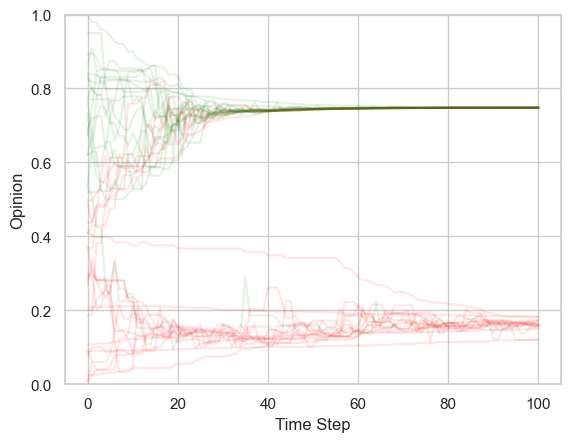

In [335]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] >= 0.5:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['opinion'])[0] < 0.5:
        c = 'red'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
    
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

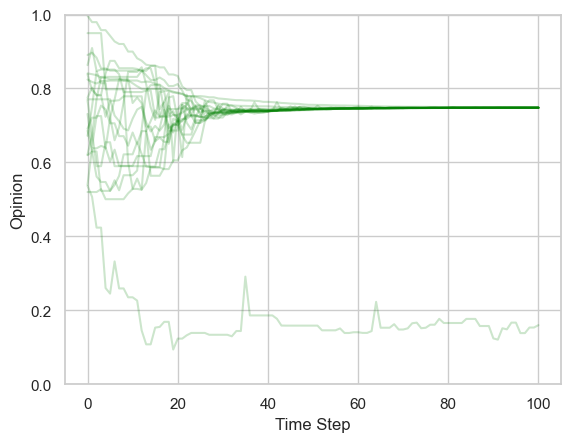

In [336]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] >= 0.5:
        c = 'green'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c, alpha = 0.2)

plt.ylim(0,1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

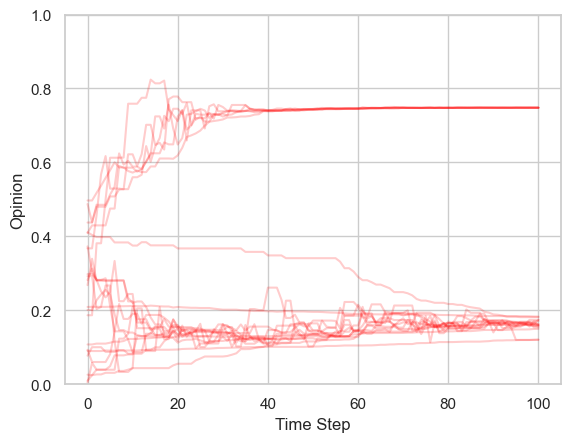

In [337]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] < 0.5:
        c = 'red'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c, alpha = 0.2)

plt.ylim(0,1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

In [315]:
data = model.datacollector.get_agent_vars_dataframe()

In [316]:
d = data.reset_index()
d = d.pivot_table(index='AgentID', columns='Step', values='opinion')
d.reset_index(inplace=True)

In [338]:
# d.head()

In [342]:
agents_data.query('Step == 0 and opinion < 0.5')

opinion  update_count  other_id  other_op  update_status
Step AgentID                                                           
0    0        0.025618             0        -1      -1.0          False
     1        0.009300             0        -1      -1.0          False
     2        0.372759             0        -1      -1.0          False
     4        0.410777             0        -1      -1.0          False
     6        0.090255             0        -1      -1.0          False
     8        0.487299             0        -1      -1.0          False
     9        0.496992             0        -1      -1.0          False
     11       0.409226             0        -1      -1.0          False
     12       0.077107             0        -1      -1.0          False
     13       0.200839             0        -1      -1.0          False
     15       0.208943             0        -1      -1.0          False
     16       0.107447             0        -1      -1.0          False
     17       0.292296             0        -1      -1.0          False
     22       0.267962             0        -1      -1.0          False
     24       0.437304             0        -1      -1.0          False
     28       0.093010             0        -1      -1.0          False
     31       0.281732             0        -1      -1.0          False
     35       0.004529             0        -1      -1.0          False
     37       0.186502             0        -1      -1.0          False
     38       0.367451             0        -1      -1.0          False
     39       0.297738             0        -1      -1.0          False

In [343]:
agents_data.query('(Step == 100 and opinion > 0.5)')

opinion  update_count  other_id  other_op  update_status
Step AgentID                                                           
100  3        0.747800            90        34  0.747951           True
     5        0.748100            96        31  0.153680          False
     7        0.748029           102        38  0.747852           True
     8        0.747948            99        12  0.160236          False
     9        0.748009           108        10  0.747973           True
     10       0.747990           107        24  0.747987           True
     11       0.748035            93        31  0.153680          False
     18       0.748001           101        11  0.748124           True
     19       0.747984            93        21  0.747986           True
     20       0.748073            94         7  0.748016           True
     21       0.747925           129        31  0.153680          False
     23       0.747955            96        34  0.747941           True
     24       0.747992           108        34  0.747924           True
     25       0.747988            89        29  0.747976           True
     26       0.747995           113        31  0.153680          False
     27       0.748664           111        33  0.747973           True
     29       0.747985           108         0  0.155861          False
     30       0.748050            98        20  0.748102           True
     32       0.748014            99         8  0.747952           True
     33       0.748134            83         5  0.747967           True
     34       0.747930           118        10  0.747993           True
     36       0.748055            85        32  0.747948           True
     37       0.748001            89         2  0.160401          False
     38       0.747981            94        28  0.164071          False

In [321]:
agents_data.query("AgentID == 0").head(15)

opinion  update_count  other_id  other_op  update_status
Step AgentID                                                           
0    0        0.027028             0        -1 -1.000000          False
1    0        0.062657             2         7  0.901393          False
2    0        0.062657             6        39  0.718963          False
3    0        0.062657             7        17  0.993082          False
4    0        0.120604            10        13  0.715070          False
5    0        0.120604            11         7  0.879831          False
6    0        0.217321            11        33  0.261112           True
7    0        0.217321            12        30  0.798672          False
8    0        0.257615            13        28  0.275859           True
9    0        0.256042            13        28  0.255329           True
10   0        0.237113            14        12  0.228543           True
11   0        0.237113            14        29  0.748781          False
12   0        0.272949            16        38  0.725693          False
13   0        0.221234            18        36  0.197818           True
14   0        0.207103            18        19  0.200705           True

In [344]:
agents_data.query("AgentID == 37").head(15)

opinion  update_count  other_id  other_op  update_status
Step AgentID                                                           
0    37       0.186502             0        -1 -1.000000          False
1    37       0.186502             0        26  0.673019          False
2    37       0.381201             3         9  0.496992          False
3    37       0.381201             5        10  0.781107          False
4    37       0.499028             5         7  0.527579           True
5    37       0.612647             7        22  0.279705          False
6    37       0.612647             7        16  0.115260          False
7    37       0.612647             7        27  0.825823          False
8    37       0.613167            10        11  0.555706           True
9    37       0.758801            12        19  0.797806           True
10   37       0.758801            12        14  0.235045          False
11   37       0.758801            14         1  0.109783          False
12   37       0.774890            17        33  0.654708           True
13   37       0.774890            17         7  0.544269          False
14   37       0.824011            17        20  0.835913           True

### Findings:

my conclusion is that this is also caused beacuse of the 2 way update process .. as from step to step and agent might go through several update processes even if it not shown in the appove dataframe, because it might be selected as a neighbor. for example, for agent 37, the opinion was updated 3 times in time step 2 even though the update statues is false. 

What's next? I will try running this case again with 1 way update instead 

## 3. Only similar agents communicate (d = 0.2 + No R) - one way update process

In [346]:
model = opinionsModel(N = 40, d = 0.2)

In [347]:
num_steps = 100 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()

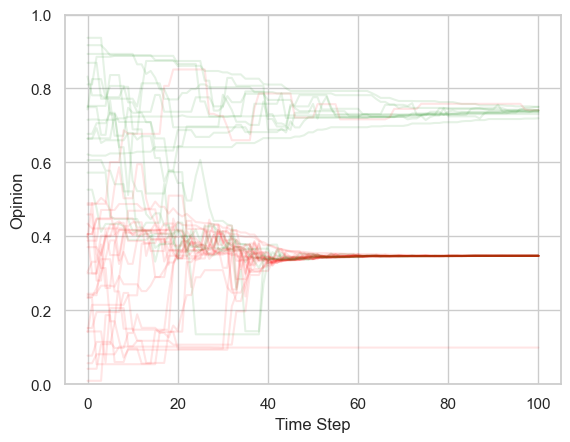

In [348]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] >= 0.5:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['opinion'])[0] < 0.5:
        c = 'red'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
    
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

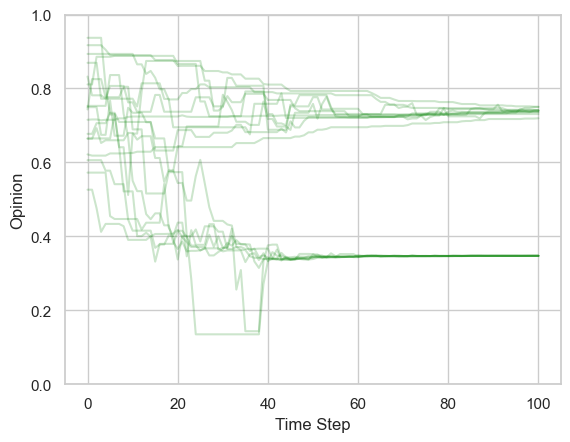

In [349]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] >= 0.5:
        c = 'green'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c, alpha = 0.2)

plt.ylim(0,1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

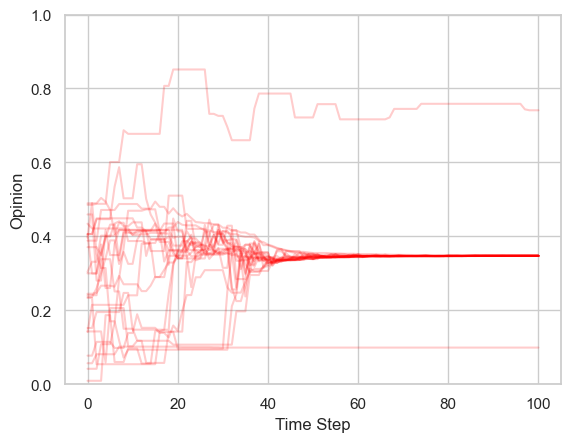

In [350]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] < 0.5:
        c = 'red'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c, alpha = 0.2)

plt.ylim(0,1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

In [356]:
df1 = agents_data.query('Step == 0 and opinion > 0.5')
df1

opinion  update_count  other_id  other_op  update_status
Step AgentID                                                           
0    2        0.832240             0        -1      -1.0          False
     4        0.749487             0        -1      -1.0          False
     5        0.811055             0        -1      -1.0          False
     6        0.752974             0        -1      -1.0          False
     9        0.917144             0        -1      -1.0          False
     14       0.869470             0        -1      -1.0          False
     15       0.621716             0        -1      -1.0          False
     18       0.893540             0        -1      -1.0          False
     22       0.715359             0        -1      -1.0          False
     23       0.664155             0        -1      -1.0          False
     25       0.664961             0        -1      -1.0          False
     26       0.526212             0        -1      -1.0          False
     30       0.572386             0        -1      -1.0          False
     33       0.937147             0        -1      -1.0          False
     34       0.606059             0        -1      -1.0          False
     35       0.677279             0        -1      -1.0          False
     37       0.743325             0        -1      -1.0          False

In [357]:
df2 = agents_data.query('(Step == 100 and opinion < 0.5)')
df2

opinion  update_count  other_id  other_op  update_status
Step AgentID                                                           
100  0        0.347176            89        25  0.347176           True
     1        0.347201            97         0  0.347176           True
     3        0.347164            99        25  0.347154           True
     6        0.347318           112        13  0.347378           True
     7        0.347090            87         5  0.741117          False
     8        0.347338           100        13  0.347378           True
     10       0.347156           108        29  0.347141           True
     11       0.347459           118        17  0.347326           True
     12       0.347248           104        27  0.347245           True
     13       0.347378           106        37  0.347481           True
     16       0.347281           102        30  0.347459           True
     17       0.347326           108        37  0.347481           True
     19       0.347196            88        33  0.740217          False
     20       0.347168            83         2  0.736405          False
     21       0.347226            97        12  0.347248           True
     23       0.347163           115        20  0.347168           True
     24       0.347289           100        17  0.347326           True
     25       0.347154            97        29  0.347141           True
     26       0.347167            89        10  0.347156           True
     27       0.347170            91        29  0.347141           True
     29       0.347141           116        14  0.749813          False
     30       0.347459           108        11  0.347473           True
     31       0.098991            97        23  0.347163          False
     32       0.347197            97        17  0.347326           True
     34       0.347178            84        23  0.347163           True
     36       0.347340           101        30  0.347459           True
     37       0.347461           106        30  0.347459           True
     38       0.347174           108         4  0.736376          False
     39       0.347183            98         3  0.347183           True

In [390]:
df1.loc[0].index

Index([2, 4, 5, 6, 9, 14, 15, 18, 22, 23, 25, 26, 30, 33, 34, 35, 37], dtype='int64', name='AgentID')

In [393]:
df2.loc[100].index

Index([ 0,  1,  3,  6,  7,  8, 10, 11, 12, 13, 16, 17, 19, 20, 21, 23, 24, 25,
       26, 27, 29, 30, 31, 32, 34, 36, 37, 38, 39],
      dtype='int64', name='AgentID')

In [396]:
print("The agents Ids with opinions moved from < 0.5 to > 0.5: " , list(set(df1.loc[0].index) & set(df2.loc[100].index)))

The agents Ids with opinions moved from < 0.5 to > 0.5:  [34, 37, 6, 23, 25, 26, 30]


In [411]:
agents_data.query("AgentID == 6")

opinion  update_count  other_id  other_op  update_status
Step AgentID                                                           
0    6        0.752974             0        -1 -1.000000          False
1    6        0.752974             1        36  0.406036          False
2    6        0.752974             2        16  0.236030          False
3    6        0.752974             2         1  0.195131          False
4    6        0.752974             4        27  0.471317          False
...                ...           ...       ...       ...            ...
96   6        0.347127           110        32  0.347097           True
97   6        0.347191           111        20  0.347235           True
98   6        0.347191           112        14  0.747503          False
99   6        0.347230           112         1  0.347257           True
100  6        0.347318           112        13  0.347378           True

[101 rows x 5 columns]

## bigger population:

In [413]:
model = opinionsModel(N = 500, d = 0.2)

In [414]:
num_steps = 500 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()

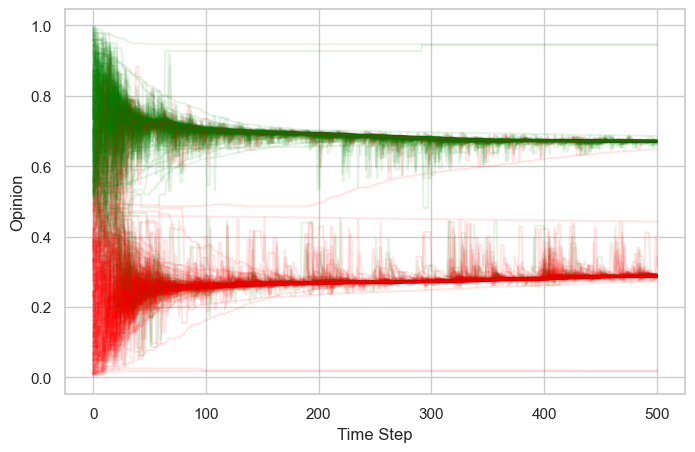

In [415]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] >= 0.5:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['opinion'])[0] < 0.5:
        c = 'red'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

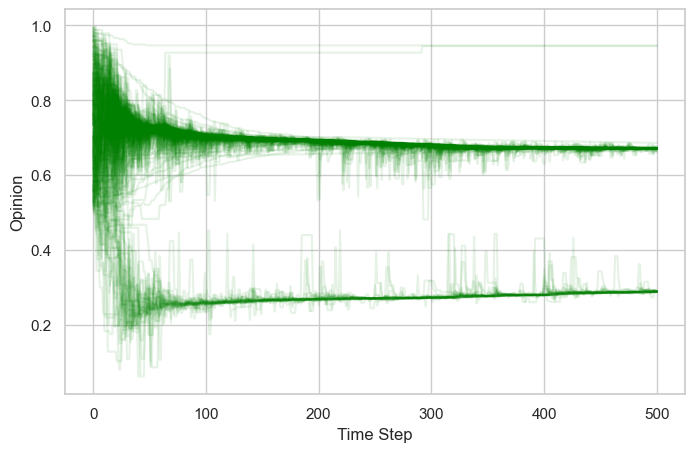

In [416]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] >= 0.5:
        c = 'green'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

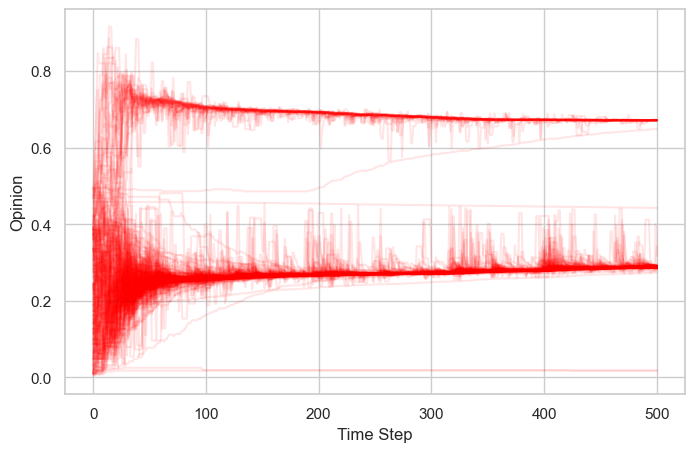

In [417]:
plt.figure(figsize=(8,  5))

for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] < 0.5:
        c = 'red'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

In [418]:
df1 = agents_data.query('Step == 0 and opinion > 0.5')
df2 = agents_data.query('(Step == 100 and opinion < 0.5)')

In [421]:
print("The agents Ids with opinions moved from < 0.5 to > 0.5: " , list(set(df1.loc[0].index) & set(df2.loc[100].index)))

The agents Ids with opinions moved from < 0.5 to > 0.5:  [135, 136, 266, 272, 17, 279, 153, 282, 284, 160, 289, 36, 423, 426, 174, 431, 50, 51, 180, 309, 187, 319, 67, 454, 333, 78, 462, 217, 347, 230, 121]


In [426]:
agents_data.query("AgentID == 136").head(20)

opinion  update_count  other_id  other_op  update_status
Step AgentID                                                           
0    136      0.771123             0        -1 -1.000000          False
1    136      0.623091             0       135  0.582568           True
2    136      0.761671             3       184  0.799607           True
3    136      0.761671             5        88  0.244008          False
4    136      0.761671             5       325  0.051595          False
5    136      0.791510             6       268  0.799679           True
6    136      0.791510             8        33  0.361026          False
7    136      0.650071             9       174  0.611352           True
8    136      0.631889             9       391  0.626912           True
9    136      0.671333             9       290  0.682131           True
10   136      0.671333             9       477  0.452766          False
11   136      0.671333            10       139  0.207865          False
12   136      0.611889            12       161  0.595616           True
13   136      0.611889            13       202  0.057134          False
14   136      0.698657            14       469  0.722409           True
15   136      0.723950            14       167  0.730874           True
16   136      0.698993            15       283  0.692161           True
17   136      0.611842            17       218  0.587985           True
18   136      0.611842            17       220  0.124250          False
19   136      0.460385            18       286  0.418924           True

### Findings:

Changing the update process to 1 way didn't change the case .. This means even with one update process per agent per time step, some agents might move their opinions from low to high and vice versa depending on who they are being communicating with

so I will leave it as its as long as I have the justification for how I am getting this senario

## 4. Peer trust + Risk Sensitivty  


In this scenario I want to figure out why in the case R = 1 (nuteral agents) it does not show dynamics similar to when there is no R in the model. 

In [493]:
model = opinionsModel(N = 3)

In [494]:
num_steps = 10 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()

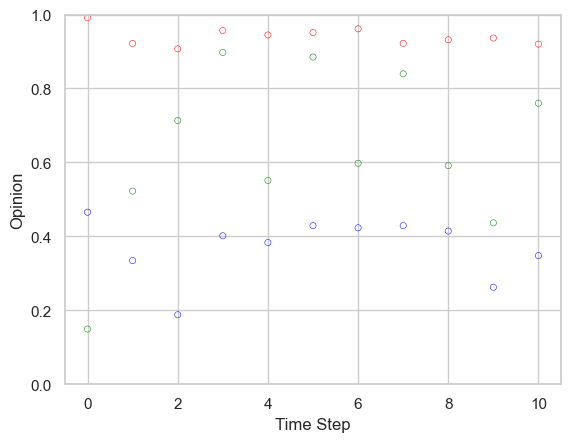

In [495]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
    sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor=c)

plt.ylim(0,1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

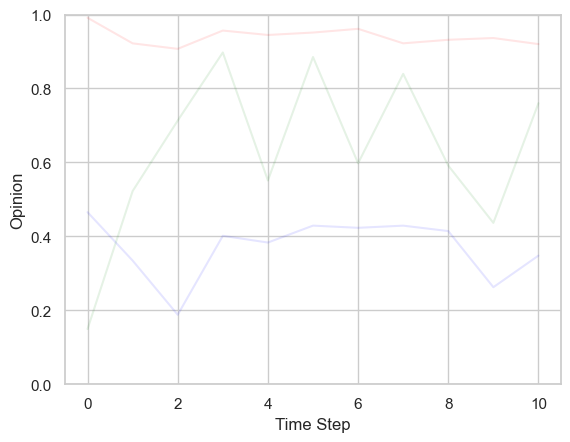

In [496]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

In [497]:
data = model.datacollector.get_agent_vars_dataframe()

In [498]:
data

opinion  peer_trust  risk_sensitivity    old_op  update_count  \
Step AgentID                                                                   
0    0        0.991343    0.172329                 2 -1.000000             0   
     1        0.149260    0.665350                 1 -1.000000             0   
     2        0.465310    0.854871                 0 -1.000000             0   
1    0        0.922110    0.172329                 2  0.991343             1   
     1        0.522441    0.665350                 1  0.709540             1   
     2        0.334365    0.854871                 0  0.465310             1   
2    0        0.907251    0.172329                 2  0.922110             1   
     1        0.713145    0.665350                 1  0.397304             3   
     2        0.187787    0.854871                 0  0.334365             2   
3    0        0.956728    0.172329                 2  0.891633             3   
     1        0.897463    0.665350                 1  0.831902             4   
     2        0.401418    0.854871                 0  0.187787             2   
4    0        0.944820    0.172329                 2  0.956728             3   
     1        0.551184    0.665350                 1  0.826446             6   
     2        0.383202    0.854871                 0  0.401418             3   
5    0        0.951367    0.172329                 2  0.944820             5   
     1        0.885154    0.665350                 1  0.813090             7   
     2        0.428952    0.854871                 0  0.383202             3   
6    0        0.961413    0.172329                 2  0.930670             6   
     1        0.597625    0.665350                 1  0.915438             8   
     2        0.423058    0.854871                 0  0.428952             4   
7    0        0.922200    0.172329                 2  0.929332             8   
     1        0.839671    0.665350                 1  0.597625             8   
     2        0.428903    0.854871                 0  0.423058             5   
8    0        0.931751    0.172329                 2  0.953989             9   
     1        0.591388    0.665350                 1  0.839671             9   
     2        0.414224    0.854871                 0  0.438892             6   
9    0        0.936548    0.172329                 2  0.931751             9   
     1        0.436413    0.665350                 1  0.549297            11   
     2        0.262337    0.854871                 0  0.414224             7   
10   0        0.920091    0.172329                 2  0.925180            10   
     1        0.760121    0.665350                 1  0.436413            13   
     2        0.347810    0.854871                 0  0.262337             7   

              other_id  other_op  
Step AgentID                      
0    0              -1 -1.000000  
     1              -1 -1.000000  
     2              -1 -1.000000  
1    0               1  0.149260  
     1               2  0.428337  
     2               0  0.923114  
2    0               1  0.297680  
     1               2  0.247573  
     2               1  0.522441  
3    0               1  0.713145  
     1               0  0.930437  
     2               0  0.907251  
4    0               1  0.567419  
     1               2  0.412736  
     2               1  0.897463  
5    0               1  0.551184  
     1               0  0.921400  
     2               0  0.938492  
6    0               1  0.885154  
     1               2  0.437775  
     2               0  0.951367  
7    0               2  0.436489  
     1               0  0.961413  
     2               0  0.949361  
8    0               2  0.428903  
     1               0  0.922200  
     2               1  0.894582  
9    0               1  0.591388  
     1               2  0.379635  
     2               1  0.817849  
10   0               1  0.431951  
     1               0  0.936548  
     2               1  

In [499]:
d = data.reset_index()
d = d.pivot_table(index='AgentID', columns='Step', values='opinion')
d.reset_index(inplace=True)

d

Step  AgentID         0         1         2         3         4         5  \
0           0  0.991343  0.922110  0.907251  0.956728  0.944820  0.951367   
1           1  0.149260  0.522441  0.713145  0.897463  0.551184  0.885154   
2           2  0.465310  0.334365  0.187787  0.401418  0.383202  0.428952   

Step         6         7         8         9        10  
0     0.961413  0.922200  0.931751  0.936548  0.920091  
1     0.597625  0.839671  0.591388  0.436413  0.760121  
2     0.423058  0.428903  0.414224  0.262337  0.347810

In [500]:
data.query('AgentID == 1')

opinion  peer_trust  risk_sensitivity    old_op  update_count  \
Step AgentID                                                                   
0    1        0.149260     0.66535                 1 -1.000000             0   
1    1        0.522441     0.66535                 1  0.709540             1   
2    1        0.713145     0.66535                 1  0.397304             3   
3    1        0.897463     0.66535                 1  0.831902             4   
4    1        0.551184     0.66535                 1  0.826446             6   
5    1        0.885154     0.66535                 1  0.813090             7   
6    1        0.597625     0.66535                 1  0.915438             8   
7    1        0.839671     0.66535                 1  0.597625             8   
8    1        0.591388     0.66535                 1  0.839671             9   
9    1        0.436413     0.66535                 1  0.549297            11   
10   1        0.760121     0.66535                 1  0.436413            13   

              other_id  other_op  
Step AgentID                      
0    1              -1 -1.000000  
1    1               2  0.428337  
2    1               2  0.247573  
3    1               0  0.930437  
4    1               2  0.412736  
5    1               0  0.921400  
6    1               2  0.437775  
7    1               0  0.961413  
8    1               0  0.922200  
9    1               2  0.379635  
10   1               0  0.936548

### Findings:

The reason for R=1 case to not bahave like the case with no R: because these agents will sometimes come in contact with alramist or non-alarmist agents (R = 0 and R = 2), which will always have opinions bellow or ablove 0.5. So due to the larger difference in the opinions, the nuteral agents will be in a constant large update in their opinions (constant bounces), therefore no convergence is reached. 

Similarlly for R = 0 and 2, even though the final opinions will be closer to one end, but it will never reach convergence because of the constant large difference in the opinions. 

And because there is no condition to force only simmilar agents to communicate, any agent can communicate with any other agents, and if there is a large difference in their opinions this will cause a big jump or fall in the next time step making it harder for the model to approach convergence.  

## 5. Peer Trust + Risk senitivty (one way update)


In [510]:
model = opinionsModel(N = 500)

In [511]:
num_steps = 500 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()

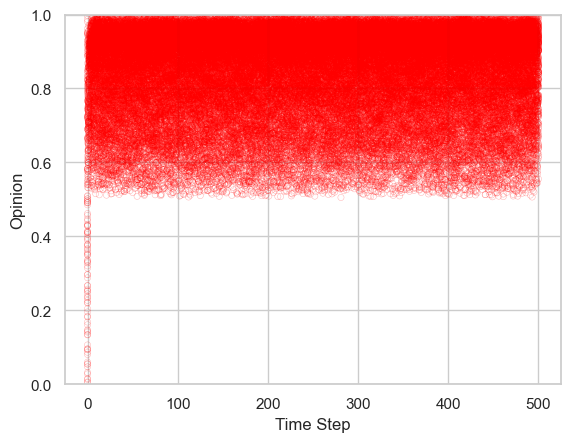

In [514]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
        sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor=c, alpha = 0.3)

plt.ylim(0,1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

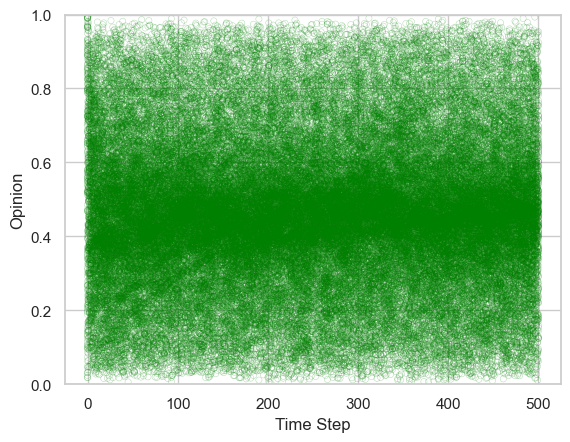

In [515]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
        sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor=c, alpha = 0.3)

plt.ylim(0,1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

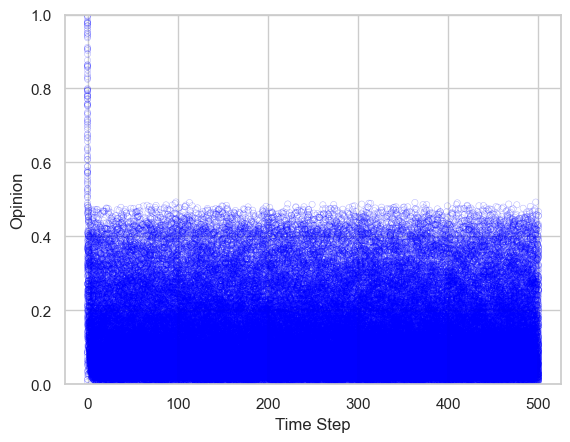

In [516]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
        sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor=c, alpha = 0.3)

plt.ylim(0,1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### Findings:

Having a one way update process didn't make any differnet.

## 6. Adding Tendency to Share (B) to the rest of the variables

### Small population

In [670]:
model = opinionsModel(N = 6)

In [671]:
num_steps = 20 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()

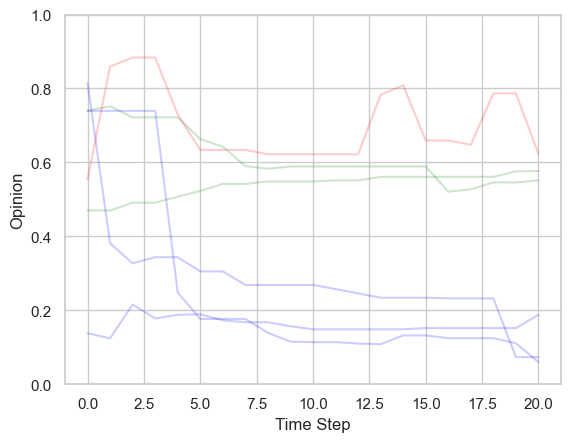

In [630]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.2)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

In [631]:
data = model.datacollector.get_agent_vars_dataframe()

In [632]:
d = data.reset_index()
d = d.pivot_table(index='AgentID', columns='Step', values='opinion')
d.reset_index(inplace=True)

d

Step  AgentID         0         1         2         3         4         5  \
0           0  0.740048  0.751747  0.721966  0.721966  0.721966  0.662937   
1           1  0.815032  0.381088  0.327099  0.343620  0.343620  0.305155   
2           2  0.553671  0.859397  0.883815  0.883815  0.729359  0.633810   
3           3  0.470012  0.470012  0.491024  0.491024  0.507278  0.522909   
4           4  0.739423  0.739423  0.739423  0.739423  0.247781  0.176532   
5           5  0.137845  0.123991  0.215586  0.177692  0.187706  0.189179   

Step         6         7         8  ...        11        12        13  \
0     0.642628  0.589976  0.583007  ...  0.589091  0.589091  0.589091   
1     0.305155  0.268409  0.268409  ...  0.257410  0.245603  0.233930   
2     0.633810  0.633810  0.621999  ...  0.621999  0.621999  0.782991   
3     0.541927  0.541927  0.548452  ...  0.551313  0.551313  0.560913   
4     0.176532  0.176532  0.139031  ...  0.113772  0.110074  0.108215   
5     0.172841  0.167547  0.167547  ...  0.148445  0.148445  0.148445   

Step        14        15        16        17        18        19        20  
0     0.589091  0.589091  0.520861  0.527110  0.545911  0.545911  0.551094  
1     0.233930  0.233930  0.232207  0.232207  0.232207  0.073279  0.073279  
2     0.808849  0.659376  0.659376  0.647616  0.786852  0.786852  0.622736  
3     0.560913  0.560913  0.560913  0.560913  0.560913  0.575834  0.576796  
4     0.131889  0.131889  0.124503  0.124503  0.124503  0.110700  0.059910  
5     0.148445  0.151772  0.151772  0.151772  0.151772  0.151772  0.187655  

[6 rows x 22 columns]

In [635]:
data.query('Step == 0')

opinion  peer_trust  risk_sensitivity  tendency_to_share  \
Step AgentID                                                              
0    0        0.740048    0.156018                 1           0.762260   
     1        0.815032    0.704882                 0           0.680541   
     2        0.553671    0.852461                 2           0.736891   
     3        0.470012    0.070383                 1           0.798209   
     4        0.739423    0.222031                 0           0.698607   
     5        0.137845    0.351982                 0           0.764196   

              old_op  update_status  share_status  update_count  other_id  \
Step AgentID                                                                
0    0          -1.0          False         False             0        -1   
     1          -1.0          False         False             0        -1   
     2          -1.0          False         False             0        -1   
     3          -1.0          False         False             0        -1   
     4          -1.0          False         False             0        -1   
     5          -1.0          False         False             0        -1   

              other_op  
Step AgentID            
0    0            -1.0  
     1            -1.0  
     2            -1.0  
     3            -1.0  
     4            -1.0  
     5            -1.0

In [636]:
data.query('Step == 1')

opinion  peer_trust  risk_sensitivity  tendency_to_share  \
Step AgentID                                                              
1    0        0.751747    0.156018                 1           0.762260   
     1        0.381088    0.704882                 0           0.680541   
     2        0.859397    0.852461                 2           0.736891   
     3        0.470012    0.070383                 1           0.798209   
     4        0.739423    0.222031                 0           0.698607   
     5        0.123991    0.351982                 0           0.764196   

                old_op  update_status  share_status  update_count  other_id  \
Step AgentID                                                                  
1    0        0.740048          False         False             0         3   
     1        0.815032           True          True             0         0   
     2        0.553671           True         False             0         5   
     3        0.470012          False          True             0         5   
     4        0.739423          False          True             0         2   
     5        0.127381           True         False             0         3   

              other_op  
Step AgentID            
1    0        0.470012  
     1        0.740048  
     2        0.137845  
     3        0.137845  
     4        0.599598  
     5        0.470012

In [633]:
data.query('AgentID == 1').head()

opinion  peer_trust  risk_sensitivity  tendency_to_share  \
Step AgentID                                                              
0    1        0.815032    0.704882                 0           0.680541   
1    1        0.381088    0.704882                 0           0.680541   
2    1        0.327099    0.704882                 0           0.680541   
3    1        0.343620    0.704882                 0           0.680541   
4    1        0.343620    0.704882                 0           0.680541   

                old_op  update_status  share_status  update_count  other_id  \
Step AgentID                                                                  
0    1       -1.000000          False         False             0        -1   
1    1        0.815032           True          True             0         0   
2    1        0.381088           True         False             0         0   
3    1        0.327099           True         False             0         0   
4    1        0.343620          False         False             0         4   

              other_op  
Step AgentID            
0    1       -1.000000  
1    1        0.740048  
2    1        0.768542  
3    1        0.721966  
4    1        0.247781

### Findings: 

instant opinion drop after one step when R = 0 and instant jump when R = 2

### Larger population 

In [641]:
model = opinionsModel(N = 50)

In [642]:
num_steps = 100 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()

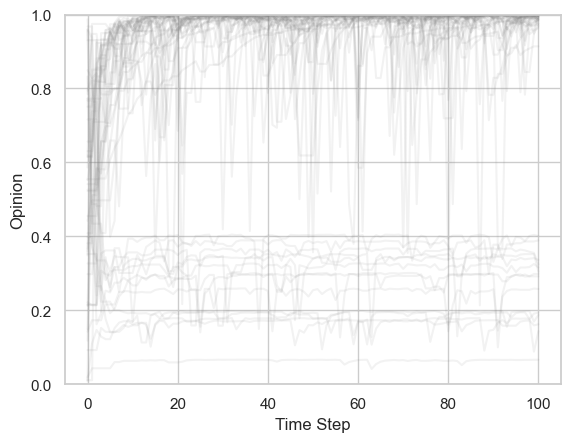

In [643]:
for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = "grey" , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

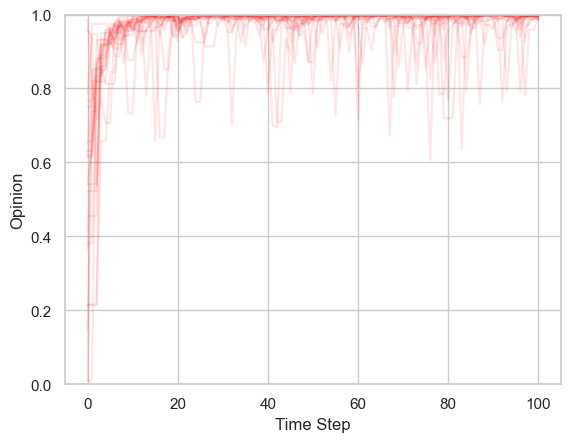

In [644]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

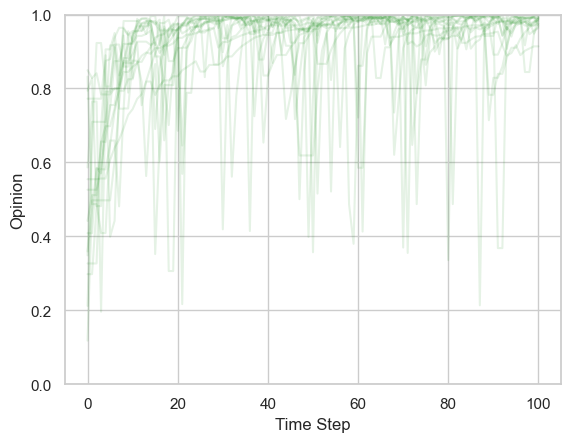

In [645]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

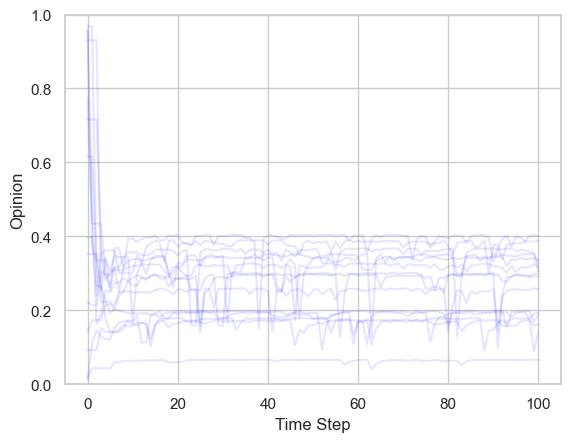

In [646]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

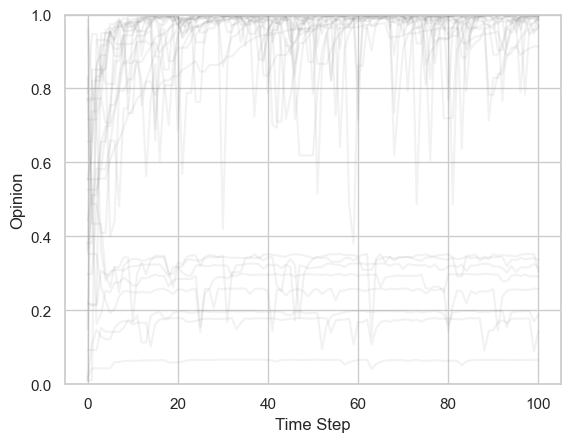

In [647]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['tendency_to_share'])[0] >= 0.5:
        c = 'gray'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

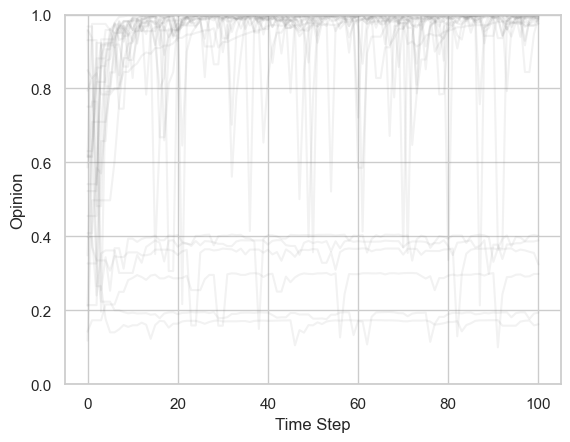

In [648]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['tendency_to_share'])[0] < 0.5:
        c = 'gray'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

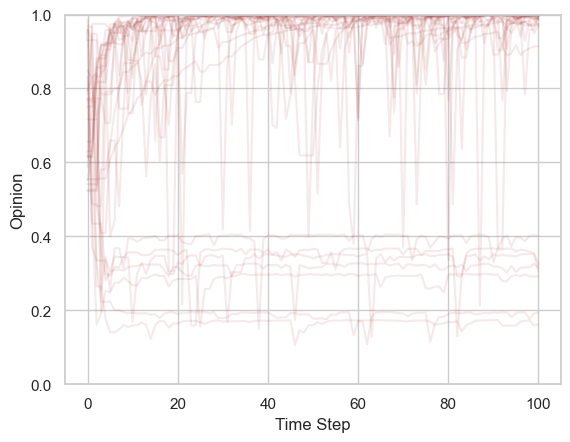

In [649]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] >= 0.5:
        c = 'brown'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

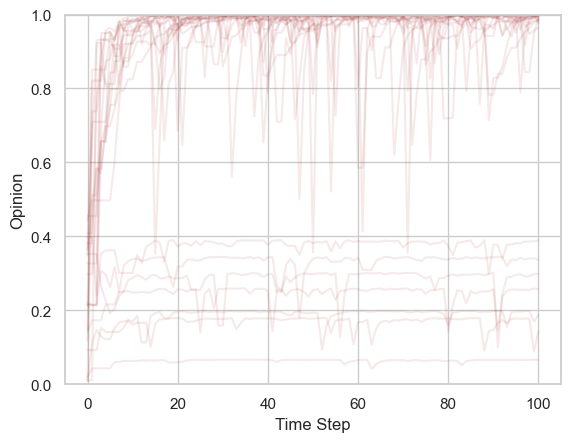

In [650]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['opinion'])[0] < 0.5:
        c = 'brown'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

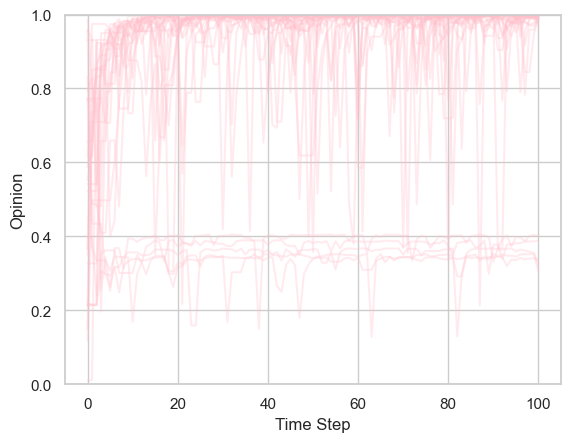

In [652]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['peer_trust'])[0] >= 0.5:
        c = 'pink'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.3)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

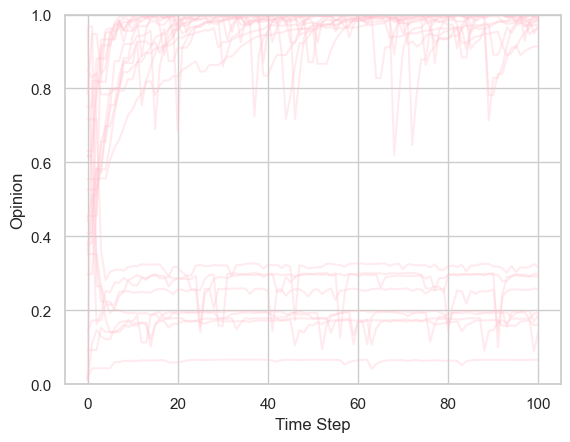

In [653]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['peer_trust'])[0] < 0.5:
        c = 'pink'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.3)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

In [674]:
model = opinionsModel(N = 1000)

In [676]:
num_steps = 50 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

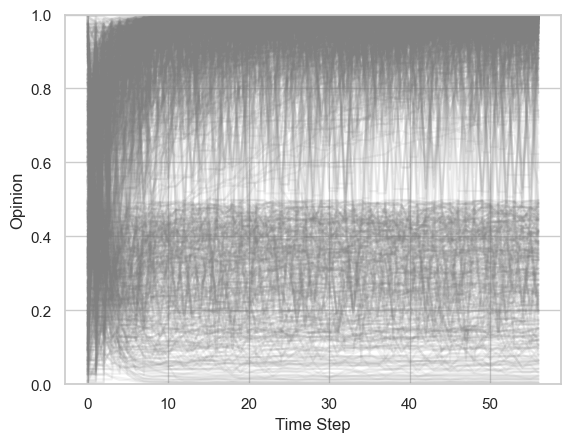

In [677]:
for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = "grey" , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

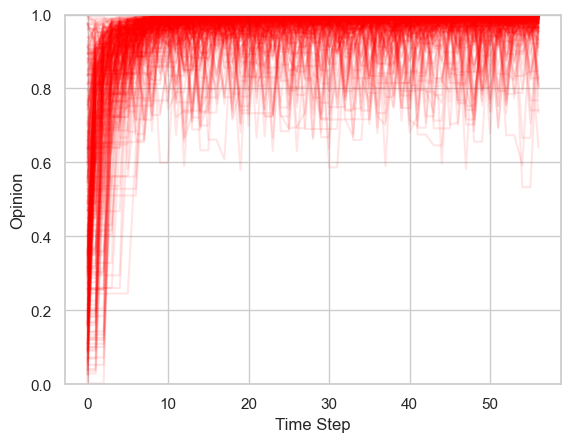

In [678]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

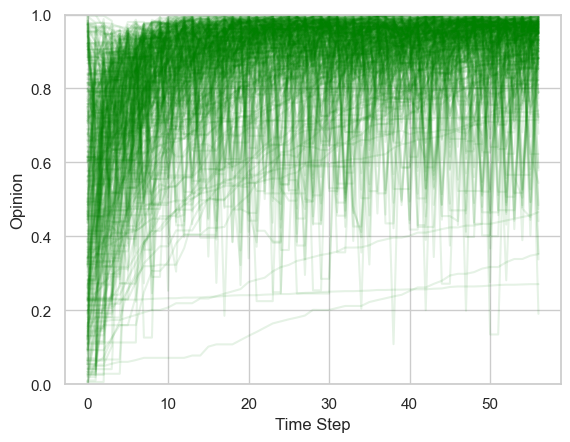

In [679]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

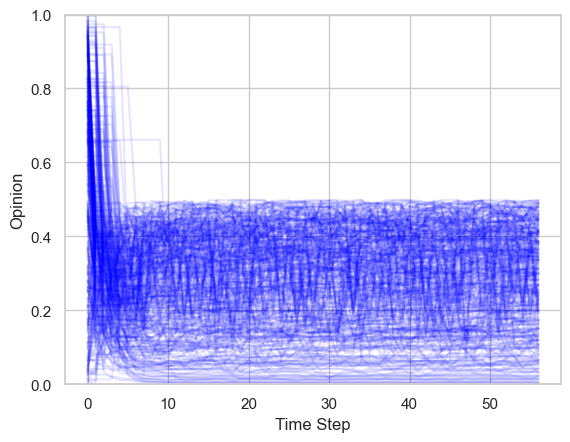

In [680]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
        sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

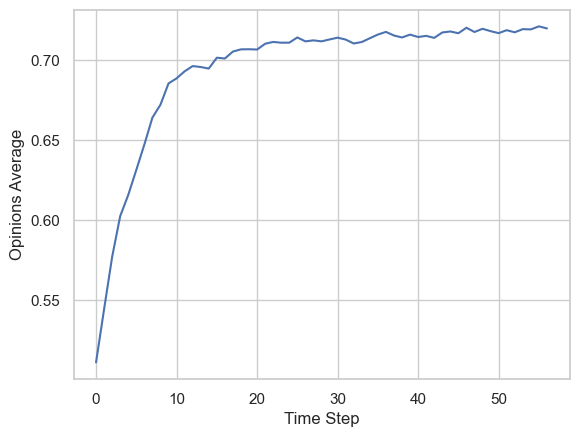

In [689]:
sns.lineplot(x=model_data.index, y="op_avg", data=model_data)

# plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinions Average")
# plt.xscale('log')
plt.show()

### Findings:

- Risk sensitivity is ther reason for the opinions never approaching convergence
- it is also causing the avergae opinions never convergeing close to 1

## 7. The model with Peer trust + Tendency to share (No R)

call the function: update_opinion_Deffuant_with_B()

In [69]:
model = opinionsModel(N = 500)

In [70]:
num_steps = 500 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()

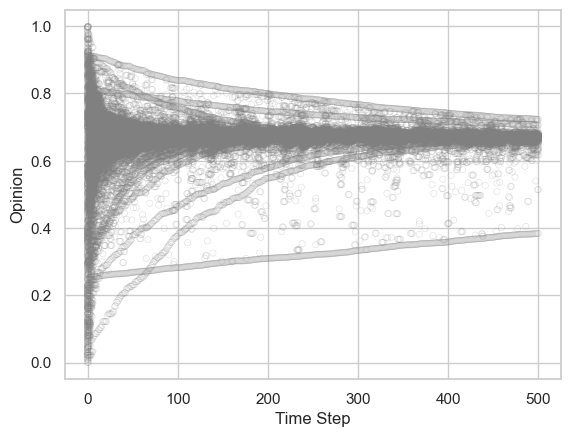

In [71]:
for i in range(model.num_agents):
    sns.scatterplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), marker='o', s=20, facecolor='none', edgecolor='grey', alpha = 0.3)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

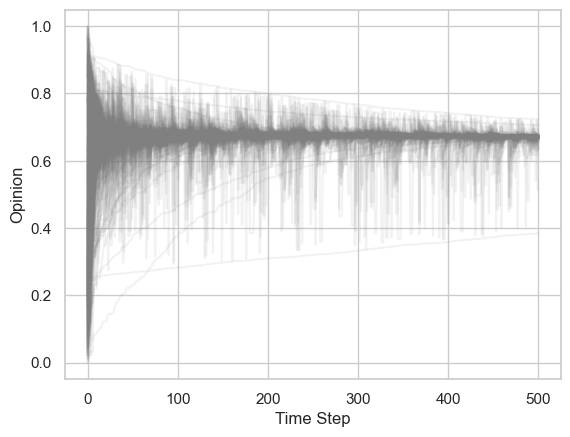

In [72]:
for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'grey' , alpha = 0.1)

plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### samller population

In [76]:
model = opinionsModel(N = 6)

In [94]:
num_steps = 20 
for _ in range(num_steps):
    model.step()

model_data = model.datacollector.get_model_vars_dataframe()
agents_data = model.datacollector.get_agent_vars_dataframe()

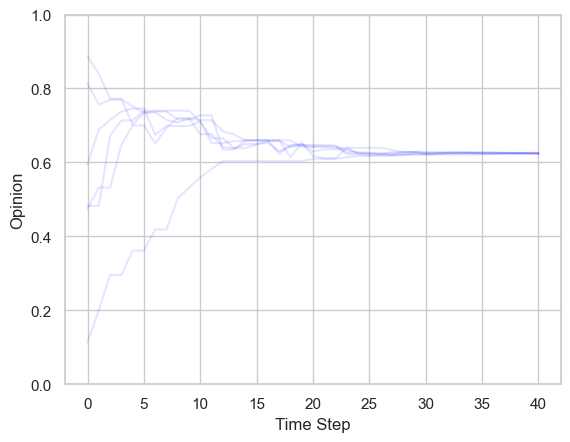

In [97]:
for i in range(model.num_agents):
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = 'blue' , alpha = 0.1)

plt.ylim(0,1)    
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

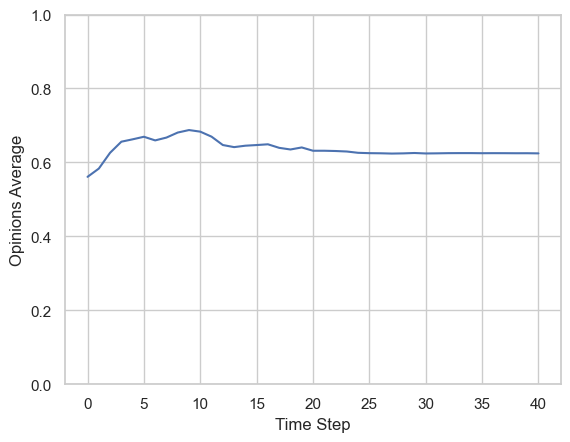

In [96]:
sns.lineplot(x=model_data.index, y="op_avg", data=model_data)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinions Average")
# plt.xscale('log')
plt.show()

In [79]:
agents_data.query("Step == 0")

opinion  peer_trust  risk_sensitivity  tendency_to_share  \
Step AgentID                                                              
0    0        0.886774    0.638206                 1           0.615088   
     1        0.474509    0.479090                 1           0.285933   
     2        0.813400    0.333961                 0           0.343411   
     3        0.594565    0.387785                 1           0.764111   
     4        0.482525    0.815269                 1           0.368332   
     5        0.113881    0.149334                 0           0.414962   

              old_op  update_status  share_status  other_id  other_op  
Step AgentID                                                           
0    0          -1.0          False         False        -1      -1.0  
     1          -1.0          False         False        -1      -1.0  
     2          -1.0          False         False        -1      -1.0  
     3          -1.0          False         False        -1      -1.0  
     4          -1.0          False         False        -1      -1.0  
     5          -1.0          False         False        -1      -1.0

In [81]:
agents_data.query("Step == 1")

opinion  peer_trust  risk_sensitivity  tendency_to_share  \
Step AgentID                                                              
1    0        0.839946    0.638206                 1           0.615088   
     1        0.532027    0.479090                 1           0.285933   
     2        0.756638    0.333961                 0           0.343411   
     3        0.688928    0.387785                 1           0.764111   
     4        0.482525    0.815269                 1           0.368332   
     5        0.199755    0.149334                 0           0.414962   

                old_op  update_status  share_status  other_id  other_op  
Step AgentID                                                             
1    0        0.886774           True          True         2  0.813400  
     1        0.532027          False         False         2  0.756638  
     2        0.837904           True          True         3  0.594565  
     3        0.594565          False          True         1  0.474509  
     4        0.482525          False         False         1  0.532027  
     5        0.113881           True         False         3  0.688928

In [82]:
agents_data.query("Step == 2")

opinion  peer_trust  risk_sensitivity  tendency_to_share  \
Step AgentID                                                              
2    0        0.772347    0.638206                 1           0.615088   
     1        0.532027    0.479090                 1           0.285933   
     2        0.769399    0.333961                 0           0.343411   
     3        0.715185    0.387785                 1           0.764111   
     4        0.672205    0.815269                 1           0.368332   
     5        0.295358    0.149334                 0           0.414962   

                old_op  update_status  share_status  other_id  other_op  
Step AgentID                                                             
2    0        0.839946           True          True         2  0.734026  
     1        0.532027          False         False         4  0.482525  
     2        0.769399          False         False         1  0.532027  
     3        0.688928           True          True         2  0.756638  
     4        0.482525           True         False         3  0.715185  
     5        0.199755           True         False         0  0.839946

### Findings:

- adding a condition for communication based on the tendency to share (B) .. made the agents to approach convergence close to a value greater than 0.5 (almost 0.8)
- In the case of having 3 agnets with the following opinions (0.7, 0.6 , 0.3) and their tendency to speak is close in value : approximatly 0.3 -> the agents with the heighest opinion will tend to speak more with a probabilty of 0.3 .. while the other 2 agents will have smaller probabilty (0.18, 0.018), That's why the final opinions will approach higher value while convergeing. **(needs revision)**
- it seams like agents with small opinions and tendency to speak will rarely share their opinions, therfore they will rarely influence other agents to reduce their opinions. -> that's why we see the majority of opinions approaching values greater that 0.5

## 8. the model with communication function based on the C code implementation

In [699]:
model = opinionsModel(N = 500)

In [700]:
num_steps = 500 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [706]:
sub_data = agents_data.query('Step <= 10')

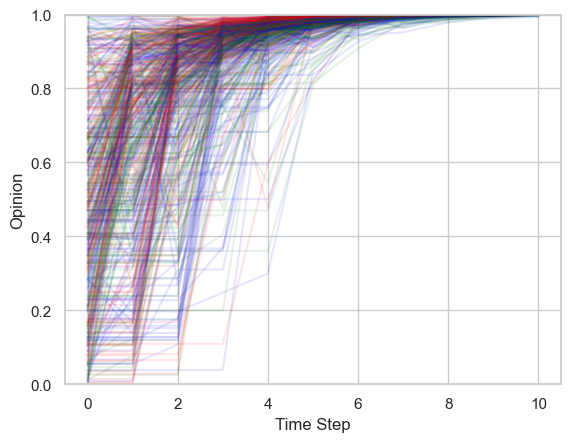

In [707]:
for i in range(model.num_agents):
    if list(sub_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
    elif list(sub_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
    elif list(sub_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
    sns.lineplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

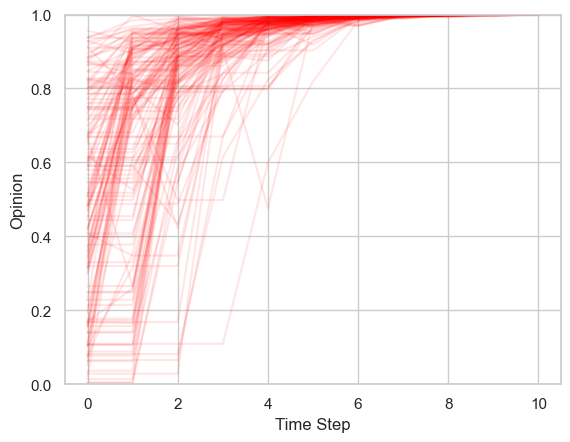

In [708]:
for i in range(model.num_agents):
    if list(sub_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
        sns.lineplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

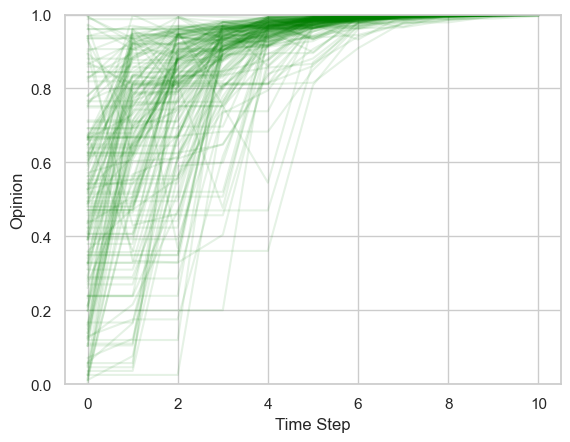

In [709]:
for i in range(model.num_agents):
    if list(sub_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
        sns.lineplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

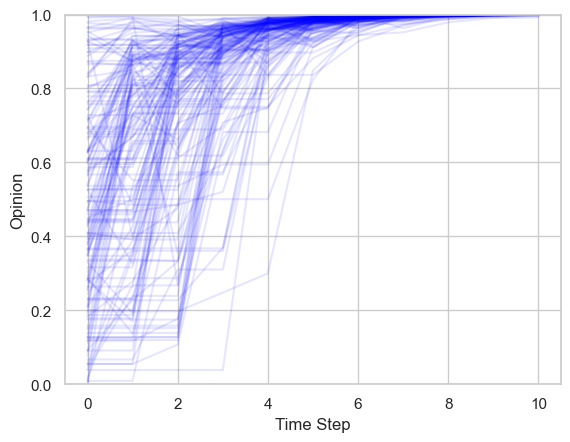

In [710]:
for i in range(model.num_agents):
    if list(sub_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
        sns.lineplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

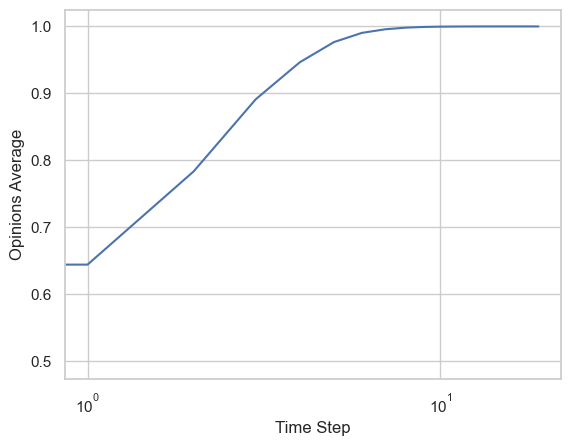

In [718]:
sns.lineplot(x=model_data.head(20).index, y="op_avg", data=model_data.head(20))

# plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinions Average")
plt.xscale('log')
plt.show()

### Smaller population

In [719]:
model = opinionsModel(N = 6)

In [720]:
num_steps = 10 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [721]:
model_data

op_avg  peer_trust_avg
0   0.508276        0.373663
1   0.785745        0.373663
2   0.869306        0.373663
3   0.942977        0.373663
4   0.976296        0.373663
5   0.981392        0.373663
6   0.992176        0.373663
7   0.995585        0.373663
8   0.996275        0.373663
9   0.997049        0.373663
10  0.997926        0.373663

In [723]:
agents_data.query("Step == 0")

opinion  peer_trust  risk_sensitivity  tendency_to_share
Step AgentID                                                           
0    0        0.053382    0.620876                 2           0.907002
     1        0.761669    0.101596                 1           0.317276
     2        0.959360    0.051188                 1           0.268814
     3        0.550653    0.598292                 2           0.761659
     4        0.370481    0.684004                 0           0.810060
     5        0.354111    0.186023                 1           0.322298

In [730]:
agents_data.query("Step == 1")

opinion  peer_trust  risk_sensitivity  tendency_to_share
Step AgentID                                                           
1    0        0.807941    0.620876                 2           0.907002
     1        0.766370    0.101596                 1           0.317276
     2        0.950685    0.051188                 1           0.268814
     3        0.901451    0.598292                 2           0.761659
     4        0.933915    0.684004                 0           0.810060
     5        0.354111    0.186023                 1           0.322298

In [725]:
agents_data.query("Step == 9")

opinion  peer_trust  risk_sensitivity  tendency_to_share
Step AgentID                                                           
9    0        0.998443    0.620876                 2           0.907002
     1        0.999156    0.101596                 1           0.317276
     2        0.999372    0.051188                 1           0.268814
     3        0.998940    0.598292                 2           0.761659
     4        0.999367    0.684004                 0           0.810060
     5        0.987019    0.186023                 1           0.322298

In [724]:
agents_data.query("AgentID == 0")

opinion  peer_trust  risk_sensitivity  tendency_to_share
Step AgentID                                                           
0    0        0.053382    0.620876                 2           0.907002
1    0        0.807941    0.620876                 2           0.907002
2    0        0.943078    0.620876                 2           0.907002
3    0        0.987310    0.620876                 2           0.907002
4    0        0.993142    0.620876                 2           0.907002
5    0        0.975031    0.620876                 2           0.907002
6    0        0.990401    0.620876                 2           0.907002
7    0        0.999079    0.620876                 2           0.907002
8    0        0.998529    0.620876                 2           0.907002
9    0        0.998443    0.620876                 2           0.907002
10   0        0.999658    0.620876                 2           0.907002

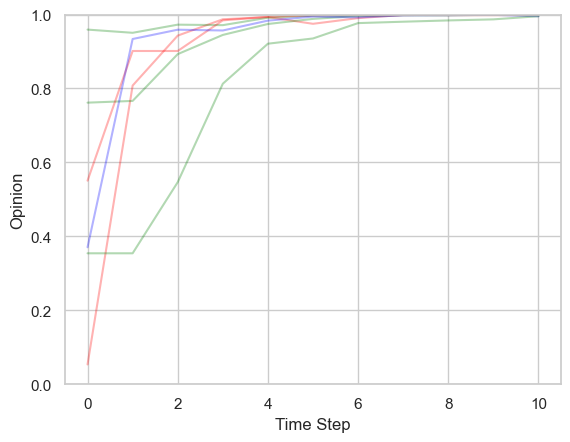

In [727]:
for i in range(model.num_agents):
    if list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 2:
        c = 'red'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 1:
        c = 'green'
    elif list(agents_data.query(f"AgentID == {i}")['risk_sensitivity'])[0] == 0:
        c = 'blue'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.3)

plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### Findings:

The reason behind having the model from the C code implementation to always converge at 1 (even when introducing institutional information) is that their code doesn't entirly match the description presented in the paper. 

In the paper, they explained that the opinion update process goes through 2 steps where the seconds step will update the opinion based on the agents' risk sensitivity as follows:
- If R = 0 -> New O = O / 2
- If R = 1 -> New O = O
- If R = 2 -> New O = ( 1 + O ) / 2


While in the C code, the risk sensitvity step was implemented like above only when updating the opinions after broadcasting the institutional information. But during the peer to peer communication, the 2nd step is as follows:
- if both agents are alarmist (both R = 2), and the speaker is pessimistic (O >= 0.5) --> the listener increases alarmism (New O = ( 1 + O ) / 2)
- if both agents are alarmist, and the speaker is optimistic (O < 0.5) --> the listener decreases alarmism (New O = O / 2)
- if the speaker is non-alarmist and pessimistic (O > 0.5) --> listener increases alarmism (New O = ( 1 + O ) / 2)

The problem in the code is that the 2nd step of the update process doesn't match what is descriped in the paper, and there is no explination for the basis of these 3 senarios or for why the focus in the codintion is the speaker opinion while ignoring the internal variables of the listener (especially their how senstitve they are to the recieved information). In addition to that, the code doesn't include any part to handle what will happen in the other cases (example differentiating when the agents are non-alarmists and netural).

Because of their implementaions, the agents will have tow cases where they will dramatically increase their opinions to values above 0.5, and only one case to reduce the opinion by half to be bellow 0.5 (and this case will rarely happen because of the fast increase in the majority of opinions so there will be rare agents with op < 0.5 to meet the condition in this case). Additionally, there is no case fot netural agents to not amplify or reduce their opinios after the first update. 

So, We can notice a quick jump in the majority of opinions close to 1 in the early time steps, then eventually converge to 1. 

## 9. All agents have the same risk sensitivty

In [159]:
# simple model
class userAgent(mesa.Agent):
    
    def __init__( self, unique_id, model, d):
        
        super().__init__(unique_id, model)
        
        self.d = d

        self.opinion = random.uniform(0, 1) # initial opinion
        self.peer_trust = random.uniform(0, 1)
        self.tendency_to_share = random.uniform(0, 1)
        
        
#         self.risk_sensitivity = 0 # low risk sensitivity
        self.risk_sensitivity = 1 # medium risk sensitivity
#         self.risk_sensitivity = 2 # high risk sensitivity
        
                
        # to keep track of the other agent in the communication
        self.other_id = -1
        self.other_op = -1
        self.old_op = -1
        self.update_count = 0
        
        self.update_status = False
        self.share_status = False
        
    
    '''
    This function is for opinion update process using peer trust - risk sensitivity 
    ''' 
    def update_opinion_Deffuant_with_risk(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 

        if len(neighbors) > 0:
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            
            # record the number of times an agent is being selected as a nieghbor
            other_agent.update_count = other_agent.update_count + 1
            
            # record the nieghbor data
            self.other_op = other_agent.opinion
            self.other_id = other_agent.unique_id
            
            saved_opinion = self.opinion
            self.old_op = saved_opinion
            
            self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

            if self.risk_sensitivity == 0:
                self.opinion = self.opinion / 2.0
            elif self.risk_sensitivity == 2:
                self.opinion = (1.0 + self.opinion) / 2.0

            other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

            if other_agent.risk_sensitivity == 0:
                other_agent.opinion = other_agent.opinion / 2.0
            elif other_agent.risk_sensitivity == 2:
                other_agent.opinion = (1.0 + other_agent.opinion) / 2.0
    
    
    '''
    This function is for opinion update process using all agent varibales 
    (peer trust - risk sensitivity - tendency to share)
    '''
    def update_opinion_Deffuant_with_R_and_B(self):

        neighbors = self.model.grid.get_neighborhood(self.pos, include_center = False) 
        if len(neighbors) > 0:
            
            other_agent = self.random.choice(self.model.grid.get_cell_list_contents(neighbors))
            saved_opinion = self.opinion
            
            # record the nieghbor data
            self.other_op = other_agent.opinion
            self.other_id = other_agent.unique_id
            
            self.old_op = saved_opinion

            # other agent speek
            speak_prob = other_agent.opinion ** (1.0 / other_agent.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                self.opinion = self.opinion + self.peer_trust * (other_agent.opinion - self.opinion)

                if self.risk_sensitivity == 0:
                    self.opinion = self.opinion / 2.0
                elif self.risk_sensitivity == 2:
                    self.opinion = (1.0 + self.opinion) / 2.0
                    
                self.update_status = True
            
            else:
                self.update_status = False
                


            # current agent speek
            speak_prob = self.opinion ** (1.0 / self.tendency_to_share)
            if random.uniform(0, 1) < speak_prob:
                other_agent.opinion = other_agent.opinion + other_agent.peer_trust * (saved_opinion - other_agent.opinion)

                if other_agent.risk_sensitivity == 0:
                    other_agent.opinion = other_agent.opinion / 2.0
                elif other_agent.risk_sensitivity == 2:
                    other_agent.opinion = (1.0 + other_agent.opinion) / 2.0
                    
                self.share_status = True
            
            else:
                self.share_status = False
                
     
    
    
                

   
    def step(self):
#         self.update_opinion_Deffuant_with_risk() ## P and R
        self.update_opinion_Deffuant_with_R_and_B() ## P & R & B
        
        
#####################################################


def opinion_avg(model):
    return sum(a.opinion for a in model.grid.get_all_cell_contents())/model.num_agents

def peer_trust_avg(model):
    return sum(a.peer_trust for a in model.grid.get_all_cell_contents())/model.num_agents

#####################################################

class opinionsModel(mesa.Model):
    
    def __init__(self, N = 100 , d = 0):
      
        self.num_agents = N
        self.d = d

        self.G = nx.complete_graph(n = self.num_agents)
        self.datacollector = mesa.DataCollector(
            model_reporters = {
                "op_avg": opinion_avg,
                "peer_trust_avg" : peer_trust_avg,
            },
            agent_reporters = {
                "opinion" : "opinion", 
                "peer_trust" : "peer_trust",
                "risk_sensitivity": "risk_sensitivity",
                "tendency_to_share" : "tendency_to_share",
                "old_op" : "old_op",
                "update_status" : "update_status",
                "share_status" : "share_status",
                "other_id" : "other_id",
                "other_op" : "other_op",
                
            }
        )

        self.grid = mesa.space.NetworkGrid(self.G)
        self.schedule = mesa.time.RandomActivation(self)

        for i, node in enumerate(self.G.nodes()):           
            a = userAgent(i, self, d)
            self.schedule.add(a)
            self.grid.place_agent(a, node)
            
        self.datacollector.collect(self)

        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        

### population of non-alarmist agents

In [113]:
model = opinionsModel(N = 50)

In [114]:
num_steps = 100 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [123]:
sub_data = agents_data.query("Step < 10")

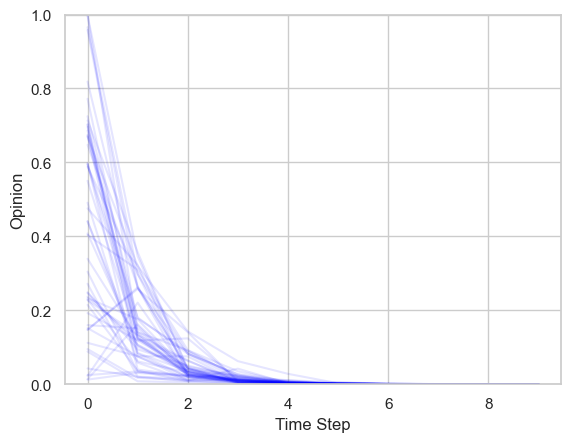

In [124]:
for i in range(model.num_agents):
    c = 'blue'
    sns.lineplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

        
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

#### all variables

In [126]:
model = opinionsModel(N = 50)

In [132]:
num_steps = 100 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

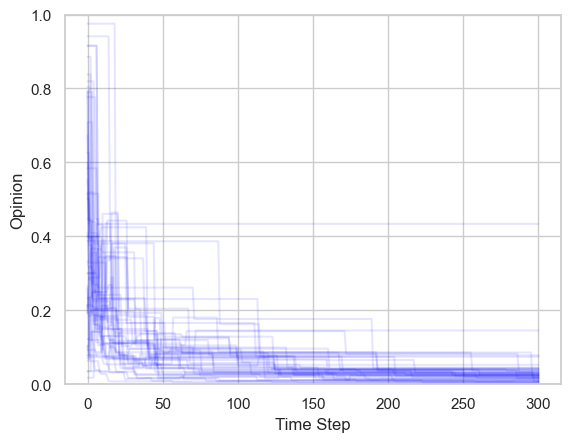

In [133]:
for i in range(model.num_agents):
    c = 'blue'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

        
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### population of alarmist agents

In [135]:
model = opinionsModel(N = 50)

In [136]:
num_steps = 100 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [138]:
sub_data = agents_data.query("Step < 10")

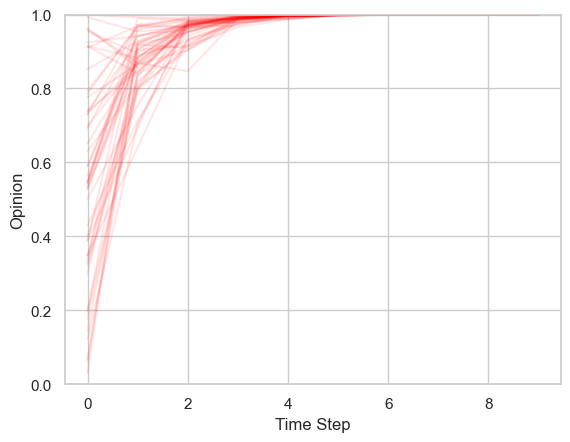

In [139]:
for i in range(model.num_agents):
    c = 'red'
    sns.lineplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

        
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

#### all variables

In [149]:
model = opinionsModel(N = 50)

In [150]:
num_steps = 100 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

In [151]:
sub_data = agents_data.query("Step < 10")

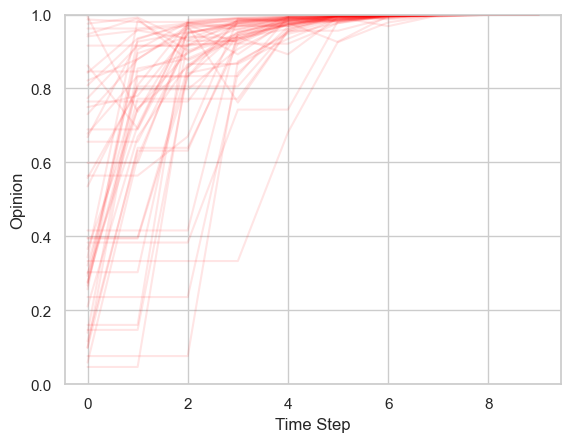

In [152]:
for i in range(model.num_agents):
    c = 'red'
    sns.lineplot(x = "Step", y = "opinion", data = sub_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

        
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

### population of netural agents

In [154]:
model = opinionsModel(N = 50)

In [155]:
num_steps = 100 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

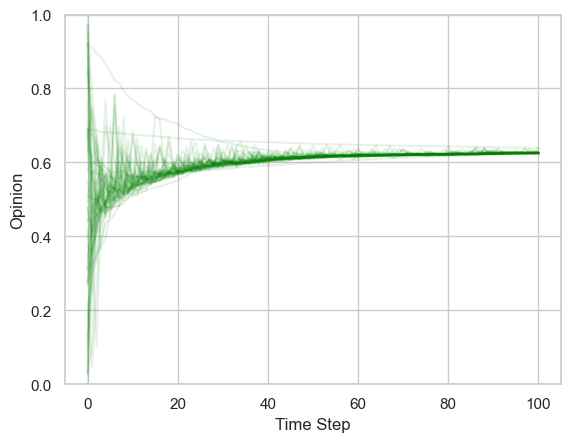

In [158]:
for i in range(model.num_agents):
    c = 'green'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

        
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()

#### all variables

In [160]:
model = opinionsModel(N = 50)

In [161]:
num_steps = 100 
for _ in range(num_steps):
    model.step()
    
agents_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

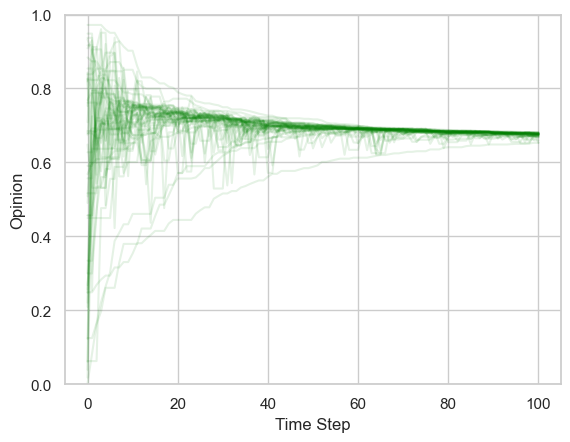

In [162]:
for i in range(model.num_agents):
    c = 'green'
    sns.lineplot(x = "Step", y = "opinion", data = agents_data.query(f"AgentID == {i}"), color = c , alpha = 0.1)

        
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Opinion")
plt.show()